# The Logistic Regression Cost Function

## Introduction

Previously, we fit our graph with logistic regression, and we saw how we can use the results of fitting our logistic regression function to our dataset.  Now, in this lesson we ask the question, well how did we get there?  That is, what's the cost function that allows us to draw this decision boundary?

Let's take another look at our graph of observations alog with the decision function.

In [2]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
import pandas as pd

def decision_boundary_y(x, coefs, intercept):
    coef_pair = coefs[0]
    return (coef_pair[0]/coef_pair[1])*x + intercept[0]/coef_pair[1]

X = dataset['data']
y = dataset['target']
df = pd.DataFrame(X, columns = dataset['feature_names'])
df['is_cancerous'] = y

scoped_df = df[['mean area', 'mean concavity']]

from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(scoped_df, y)

area_values = list(range(500, 1000, 5))
boundaries = [decision_boundary_y(idx, model.coef_, model.intercept_) for idx in area_values]

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
# decision_trace = trace_values(x_values=area_values, y_values=boundaries, mode = 'lines', name = '-3.47*x_1 -0.008*x_2  = 0')

# layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'mean concavity', 'range': [0, .5]}, 'title': 'Is it cancerous?'}
# plot([non_cancerous_trace, cancerous_trace,  decision_trace], layout = layout)

## Our Initial Attempts

Let's go through the first cost function that may come to mind.  This is simply our ordinary least squares that we saw from linear regression.  This did a good job of predicting our prices and other real values, so why shouldn't it be able to predict the numbers of zero and one.  Let's move back to just one feature input to give this a shot.

In [10]:
mean_area = df['mean area']
y = df['is_cancerous']


from sklearn.linear_model import LinearRegression, LogisticRegression
lin_model = LinearRegression()
X = mean_area.to_numpy().reshape(-1, 1)
lin_model.fit(X, y)

log_model = LogisticRegression(fit_intercept=False)
log_model.fit(X, y)
log_model.coef_

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
import numpy as np
x_inputs = np.array(list(range(0, 1500))).reshape(-1, 1)
x_inputs_log = np.array(list(range(500, 700))).reshape(-1, 1)
lin_predictions = lin_model.predict(x_inputs)
logistic_predictions = log_model.decision_function(x_inputs_log)

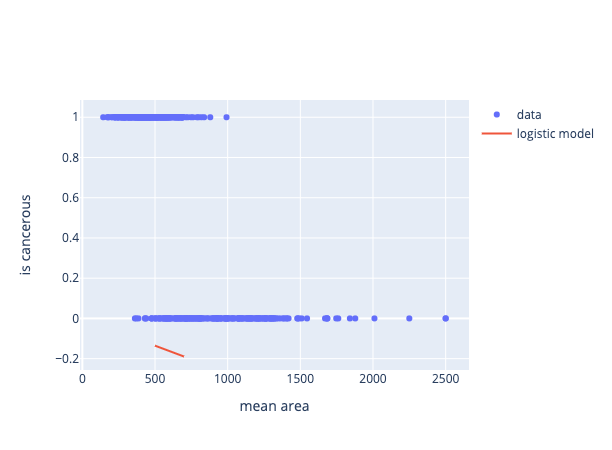

In [14]:
from graph import trace_values, plot

mean_area = df['mean area']
y = df['is_cancerous']

data_trace = trace_values(mean_area, y)

lin_predictions_trace = trace_values(x_inputs.flatten(), lin_predictions, mode = 'lines', name = 'linear model')
logisitic_predictions_trace = trace_values(x_inputs_log.flatten(), logistic_predictions, mode = 'lines', name = 'logistic model')


plot([data_trace,  logisitic_predictions_trace], {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'is cancerous'}})

The problem with our linear model is that it tries to get close to the points.  That's what happens when we have an residual sum of squares model: our model is penalized if it does not come close to outliers, so it gets pulled towards them.  With logistic regression, however we don't need our decision boundary to come close to our outliers.  We only need to correctly categorize them.

So now that residual sum of squares is out of the way, let's consider some other cost functions that could apply.  A simple one, perhaps is simply **zero one loss**.  This tries out different decision function and increases the cost function each time a datapoint is misclassified.  In our example, zero one loss, would increase our loss by one for each cancerous cell predicted to benign, and each benign cell to be cancerous.

Let's compare the log loss function with zero-one loss.

### A formal exploration of loss

Let's begin to code our zero one loss.  The first step we'll make is to change our benign cancer labels from zero to the number -1.  So now, negative 1 represents benign and positive 1 represents cancerous.  We'll see later on how using labels as $\{-1, 1\}$ can help us.  For right now, let's implement it.

In [96]:
mean_area_df = df.loc[:, ['mean area', 'is_cancerous']]
mean_area_df[:3]

,mean area,is_cancerous
0,1001.0,0
1,1326.0,0
2,1203.0,0


We can change our labels with the following: 

In [107]:
new_labels = mean_area_df['is_cancerous'].map({0: -1, 1: 1})
mean_area_df.loc[:, 'y'] = new_labels
mean_area_df[18:22]

,mean area,is_cancerous,y
18,1260.0,0,-1
19,566.3,1,1
20,520.0,1,1
21,273.9,1,1


Now let's add in our predictions.

In [108]:
mean_area = mean_area_df['mean area'].to_numpy().reshape(-1, 1)
predictions = log_model.predict(mean_area)
mean_area_df.loc[:, 'predictions'] = predictions

In [109]:
mean_area_df[:5]

,mean area,is_cancerous,y,predictions
0,1001.0,0,-1,0
1,1326.0,0,-1,0
2,1203.0,0,-1,0
3,386.1,0,-1,1
4,1297.0,0,-1,0


Ok, now that we formatted our data, let's write a formula for our zero one loss function:

In [81]:
def zero_one_loss(actual, expected):
    if actual == expected:
        return 0
    else:
        return 1

So we could use this function with `apply` to create a zero one loss for each row.  Notice, that we can also write our zero one loss function as the following:

In [114]:
def zero_one_loss_rewrite(actual, expected):
    if actual*expected == 1:
        return 0
    else:
        return 1

Let's think about why our `zero_one_loss_rewrite` function works.

If we make predict the correct label, this means we either:

* $h(x) = -1$, and $y = -1$, or
* $h(x) = 1$, and $y = 1$

Either way, when we make our prediction, $y \cdot h(x) = 1$.

And if we make an incorrect prediction, then our hypothesis and observed will have opposite signs and $y \times h(x) = -1$

So once again, here is our loss function.

In [ ]:
def zero_one_loss_rewrite(actual, expected):
    if actual*expected == 1:
        return 0
    else:
        return 1

And this is how we can translate this into a mathematical formula.

$\ell_{0/1} = 1 \{ y \cdot h_\theta(x) = 1 \} $

Those braces mean that we are working with an indicator function.  An indicator function is like an if else statement in code.  So we are saying to return 1 if y times x is one, and zero otherwise.

Our technique of multiplying $y$ by our hypothesis is also useful when our hypothesis is our score, the soft label.  Let's look at a couple examples: 

* score = -3, $y = -1$
* score = -3, $y = 1$
* score = 3, $y = 1$
* score = 3, $y = -1$

So if we multiply $y \cdot score$, we will still get positive results when we predict correctly, and negative results when we predict incorrectly.  But this time, we will also capture if we were correct and confident, or wrong and confident.  Let's plot $y \cdot score$ along with our zero loss function.

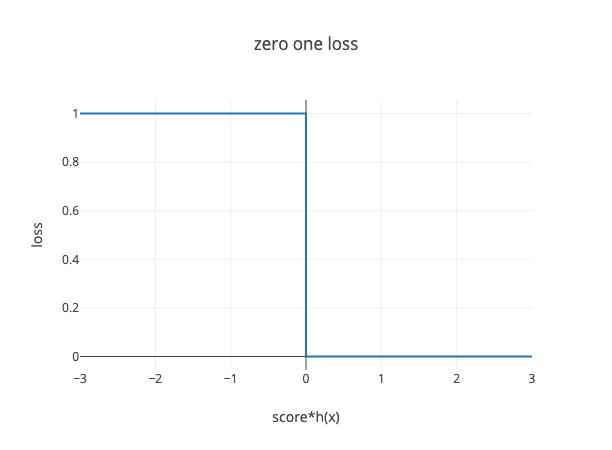

In [174]:
composite_scores = [-3, -2, -1, 0, 0, 1, 2, 3]
losses = [1, 1, 1, 1, 0, 0, 0, 0]
trace = trace_values(composite_scores, losses, mode = 'lines', name = 'zero one loss')
plot([trace], layout = {'title': 'zero one loss', 'xaxis': {'title': 'score*h(x)'}, 'yaxis': {'title': 'loss'}})

So notice that zero one loss is an all or nothing proposition.  If we are not confident and wrong, we are penalized just as much as if we are confident and wrong.  

### Log Loss

To take into account the probabilities our logistic function assigned to our various datapoints, we can move from zero one loss to log loss.  With this cost function, our hypothesis functions will be penalized most when confidently and incorrectly classifying a datapoint.

Let's understand a couple of things about taking the log of a number.

In [129]:
np.log(1)

0.0

In [135]:
np.log(.1)

-2.3025850929940455

In [136]:
np.log(.00001)

-11.512925464970229

In [137]:
np.log(100)

4.605170185988092

And we plot the log like so:

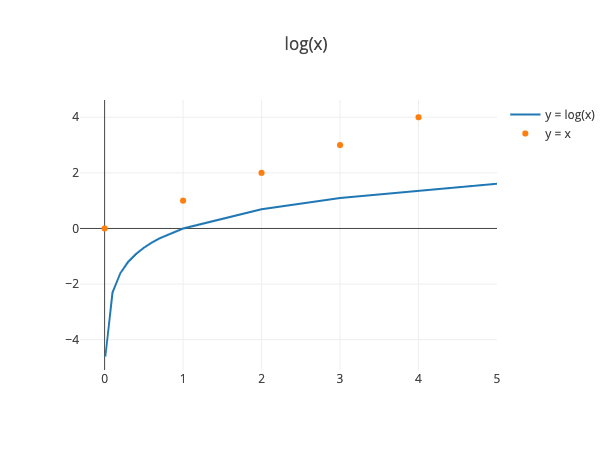

In [157]:
x_values = [.01, .1, .2, .3, .4, .5, .6, .7, 1, 2, 3, 5]
log_values = np.log(x_values)
log_trace = trace_values(x_values, log_values, mode = 'lines', name = 'y = log(x)')
x_is_y = trace_values(list(range(0, 5)), list(range(0, 5)), name = 'y = x')
plot([log_trace, x_is_y], layout = {'title': 'log(x)', })

Ok, so now let's see how we can use the log function in logistic regression.

$$ \ell_{logistic} = log (1 + \frac{1}{e^{y\cdot h_\theta(x)}})$$ 

This is our loss function.  Like always, we'll better understand this function by plugging in some numbers.

* When we are confident and correct, then $y \cdot h_\theta(x)$ is large and positive, and $\ell_{logistic} \approx log(1 + 0) = 0 $ 
* When we are confident and incorrect, then $y \cdot h_\theta(x)$ is large and negative, which gives us $\ell_{logistic} \approx log(1 + e^{|score|}) \approx score $


Let's compare our logistic loss plot with our zero one loss plot.

In [187]:
def logistic_loss(actual, expected):
    return np.log(1 + 1/np.exp(actual*expected))

In [200]:
actual = np.array([1, 1, 1, 1, 1, 1, 1, 1])
expected = np.array([-3, -2, -1, -.3, .3, 1, 2, 3])
multiplied_scores = actual * expected

logistic_losses = [logistic_loss(actual, expected) for actual, expected in zip(actual, expected)]

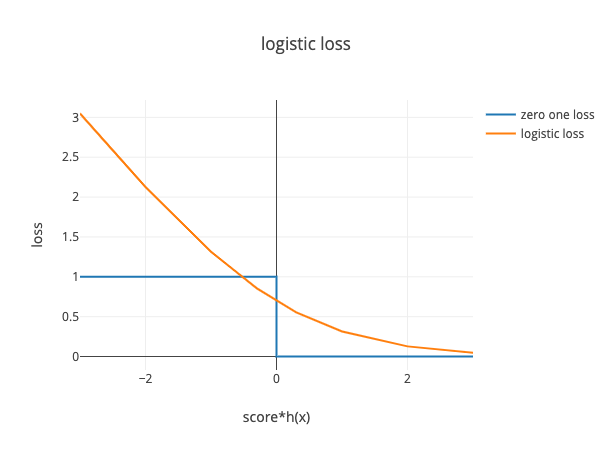

In [201]:
composite_scores = [-3, -2, -1, 0, 0, 1, 2, 3]
losses = [1, 1, 1, 1, 0, 0, 0, 0]

zero_one_trace = trace_values(composite_scores, losses, mode = 'lines', name = 'zero one loss')



logistic_loss_trace = trace_values(multiplied_scores, logistic_losses, mode = 'lines', name = 'logistic loss')

plot([zero_one_trace, logistic_loss_trace], layout = {'title': 'logistic loss', 'xaxis': {'title': 'score*h(x)'}, 'yaxis': {'title': 'loss'}})

So this the loss function we use for logistic regression.  The process of fitting our line now just uses gradient descent - like we saw in linear regression.  That is we try different parameters for our hypothesis function, input them into our logistic cost function, and choose the hypothesis function that minimizes our cost function.

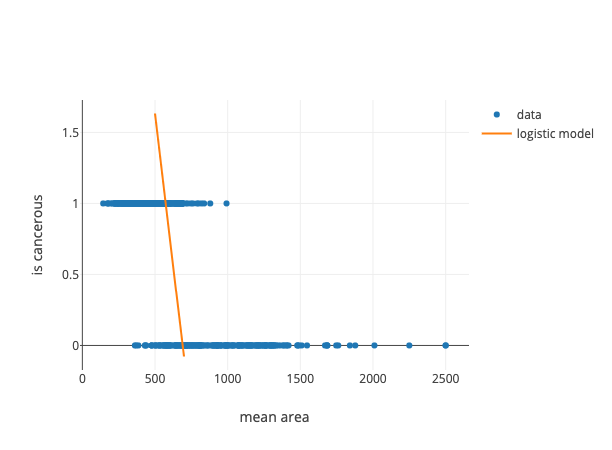

In [182]:
from graph import trace_values, plot

mean_area = df['mean area']
y = df['is_cancerous']

data_trace = trace_values(mean_area, y)

lin_predictions_trace = trace_values(x_inputs.flatten(), lin_predictions, mode = 'lines', name = 'linear model')
logisitic_predictions_trace = trace_values(x_inputs_log.flatten(), logistic_predictions, mode = 'lines', name = 'logistic model')


plot([data_trace,  logisitic_predictions_trace], {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'is cancerous'}})

In [205]:
lin_model.coef_
# -0.00097

lin_model.intercept_
# 1.265884

1.2658845158365344

In [204]:

coef = .00090
#total_costs = [ total_cost(coef, df) for coef in coefs]
def total_cost(coef, df):
    expecteds = (df['mean area']*coef).to_list()
    actuals = df['y']
    return sum([logistic_loss(actual, expected) for actual, expected in zip(actuals, expecteds)])


# trace_values(coefs, total_costs)

1.2658845158365344

### Summary

### Resources

[logistic regression cost](https://www.internalpointers.com/post/cost-function-logistic-regression)

* Talk about the score and the logistic function combined, 
* And the effects of increasing or decreasing the slope, or adding a constant to the score.